In [19]:
import os
import numpy as np
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint

In [21]:
# Paths
data_dir = 'C:\\Users\\Hp\\Downloads\\Anemia_2'
save_dir = 'C:\\Users\\Hp\\Downloads\\Anemia_5'

# Load and preprocess data
data = []
dirs = os.listdir(data_dir)

for i in dirs:
    path = os.path.join(data_dir, i)
    for img in os.listdir(path):
        image = cv.imread(os.path.join(path, img))
        image = cv.resize(image, (128, 128))  # Resize to 128x128
        data.append([image, i])

images = []
labels = []

for img, lab in data:
    images.append(img)
    labels.append(lab)

# Convert to numpy arrays and normalize images
images = np.array(images) / 255.0  # Normalize pixel values
labels = np.array(labels)

# Encode labels
le = LabelEncoder()
labels = le.fit_transform(labels)

# Split data into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.2, random_state=42
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42
)

# Reshape data for SMOTE (SMOTE requires 2D data)
x_train_flat = x_train.reshape((x_train.shape[0], -1))

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_flat, y_train)

# Reshape data back to original dimensions
x_train_resampled = x_train_resampled.reshape((-1, 128, 128, 3))

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train_resampled), 
    y=y_train_resampled
)
class_weights = dict(enumerate(class_weights))

print(f"Class Weights: {class_weights}")

Class Weights: {0: 1.0, 1: 1.0}


In [26]:
# Define the CNN model with an explicit Input layer
model = Sequential([
    Input(shape=(128, 128, 3)),  # Explicit Input layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,748,225 (10.48 MB)

 Trainable params: 2,748,225 (10.48 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Define the ModelCheckpoint callback
checkpoint_path = os.path.join(save_dir, 'model_checkpoint.keras')
checkpoint = ModelCheckpoint(
    checkpoint_path, 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max'
)

# Train the model
history = model.fit(
    x_train_resampled, y_train_resampled,
    epochs=40,
    batch_size=8,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint],
    class_weight=class_weights  # Pass class weights
)

# Save the entire model
model_path = os.path.join(save_dir, 'anemia_cnn_model.keras')
model.save(model_path)

print(f"Model saved to {model_path}")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/40
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4959 - loss: 0.6968
Epoch 1: val_accuracy improved from -inf to 0.62441, saving model to C:\Users\Hp\Downloads\Anemia_5\model_checkpoint.keras
508/508 ━━━━━━━━━━━━━━━━━━━━ 39s 71ms/step - accuracy: 0.4959 - loss: 0.6968 - val_accuracy: 0.6244 - val_loss: 0.6883
Epoch 2/40
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5363 - loss: 0.6885
Epoch 2: val_accuracy improved from 0.62441 to 0.64554, saving model to C:\Users\Hp\Downloads\Anemia_5\model_checkpoint.keras
508/508 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - accuracy: 0.5363 - loss: 0.6884 - val_accuracy: 0.6455 - val_loss: 0.6660
Epoch 3/40
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5729 - loss: 0.6711
Epoch 3: val_accuracy improved from 0.64554 to 0.71831, saving model to C:\Users\Hp\Downloads\Anemia_5\model_checkpoint.keras
508/508 ━━━━━━━━━━━━━━━━━━━━ 36s 70ms/step - accuracy: 0.5730 - loss: 0.6710 - val_accuracy: 0.7183 - val_loss: 0.6301
Epoch 4

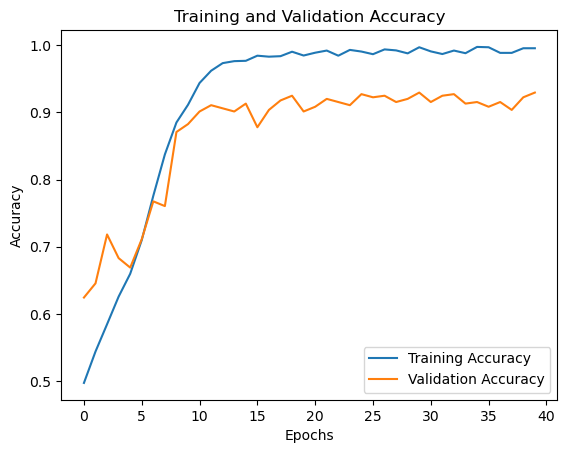

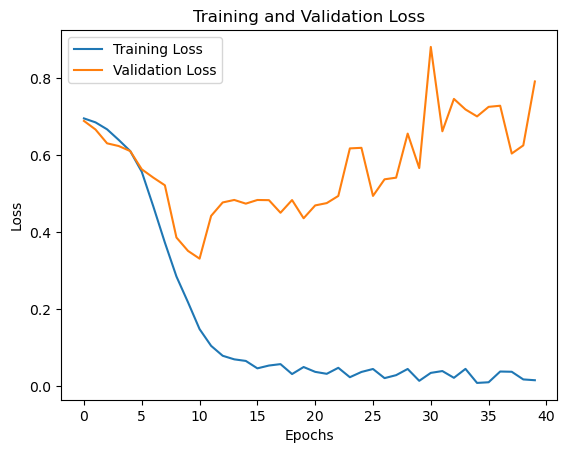

In [32]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

  2/107 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step  

C:\Users\Hp\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_159']. Received: the structure of inputs=*
  warnings.warn(


107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Random Forest Accuracy: 0.8969555035128806


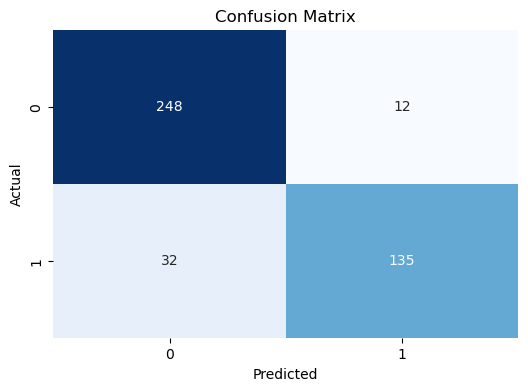

In [34]:
# Define the intermediate layer for feature extraction
feature_extractor = Model(inputs=model.inputs, outputs=model.layers[-5].output)

# Extract features from intermediate layer
train_features = feature_extractor.predict(x_train)
test_features = feature_extractor.predict(x_test)

# Reshape features for Random Forest classifier
train_reshaped = train_features.reshape(train_features.shape[0], -1)
test_reshaped = test_features.reshape(test_features.shape[0], -1)

# Train Random Forest classifier
rf = RandomForestClassifier()
rf.fit(train_reshaped, y_train)

# Predict using Random Forest classifier
y_pred_rf = rf.predict(test_reshaped)

# Calculate accuracy
rf_accuracy = accuracy_score(y_pred_rf, y_test)
print(f"Random Forest Accuracy: {rf_accuracy}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(os.path.join(save_dir, 'Confusion_Matrix.png'))
plt.show()

Epoch 1/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9809 - loss: 0.0749
Epoch 1: val_accuracy improved from -inf to 0.94836, saving model to C:\Users\Hp\Downloads\Anemia_5\model_checkpoint_batch16.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - accuracy: 0.9809 - loss: 0.0749 - val_accuracy: 0.9484 - val_loss: 0.2582
Epoch 2/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9902 - loss: 0.0239
Epoch 2: val_accuracy improved from 0.94836 to 0.96948, saving model to C:\Users\Hp\Downloads\Anemia_5\model_checkpoint_batch16.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.9902 - loss: 0.0239 - val_accuracy: 0.9695 - val_loss: 0.3186
Epoch 3/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9977 - loss: 0.0065
Epoch 3: val_accuracy did not improve from 0.96948
254/254 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.9977 - loss: 0.0065 - val_accuracy: 0.9695 - val_loss: 0.2864
Epoch 4/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accu

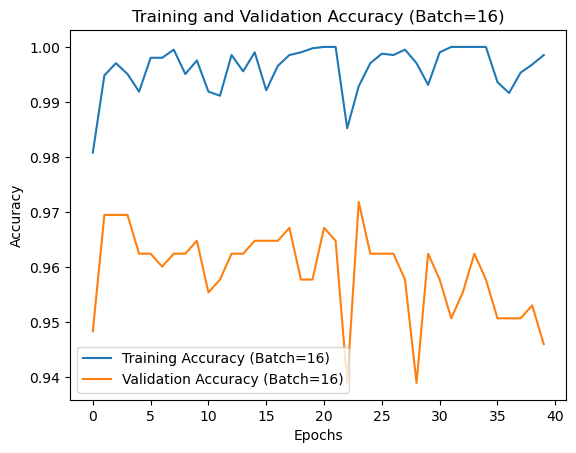

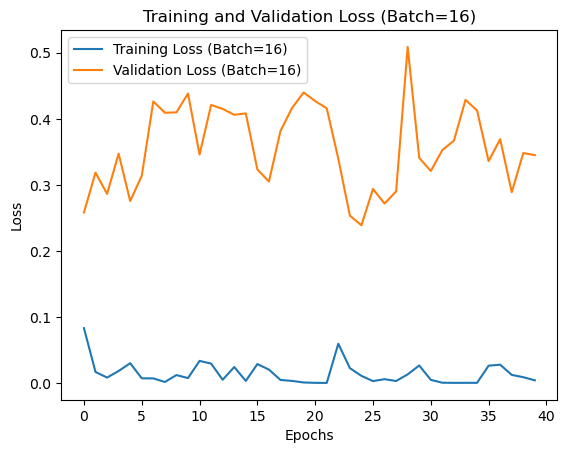

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


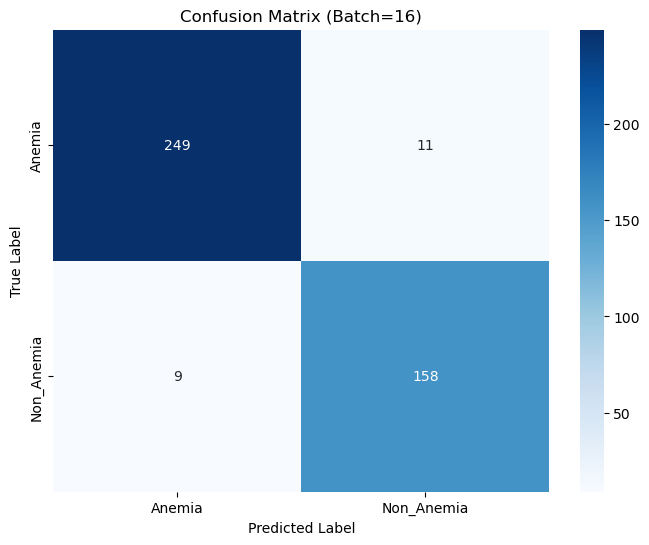

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Recreate the optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Update the checkpoint path for the new training session
checkpoint_path_16 = os.path.join(save_dir, 'model_checkpoint_batch16.keras')
checkpoint_16 = ModelCheckpoint(
    checkpoint_path_16, 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max'
)

# Train the model again with a batch size of 16
history_16 = model.fit(
    x_train_resampled, y_train_resampled,
    epochs=40,
    batch_size=16,  # Batch size changed to 16
    validation_data=(x_val, y_val),
    callbacks=[checkpoint_16],  # Use the updated checkpoint
    class_weight=class_weights  # Pass class weights
)

# Save the entire model after retraining
model_path_16 = os.path.join(save_dir, 'anemia_cnn_model_batch16.keras')
model.save(model_path_16)
print(f"Model saved to {model_path_16}")

# Evaluate the model on the test set
test_loss_16, test_accuracy_16 = model.evaluate(x_test, y_test)
print(f"Test Accuracy with batch size 16: {test_accuracy_16}")

# Plot training and validation accuracy for batch size 16
plt.plot(history_16.history['accuracy'], label='Training Accuracy (Batch=16)')
plt.plot(history_16.history['val_accuracy'], label='Validation Accuracy (Batch=16)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Batch=16)')
plt.show()

# Plot training and validation loss for batch size 16
plt.plot(history_16.history['loss'], label='Training Loss (Batch=16)')
plt.plot(history_16.history['val_loss'], label='Validation Loss (Batch=16)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Batch=16)')
plt.show()

# Generate predictions and confusion matrix
y_pred = (model.predict(x_test) > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (Batch=16)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


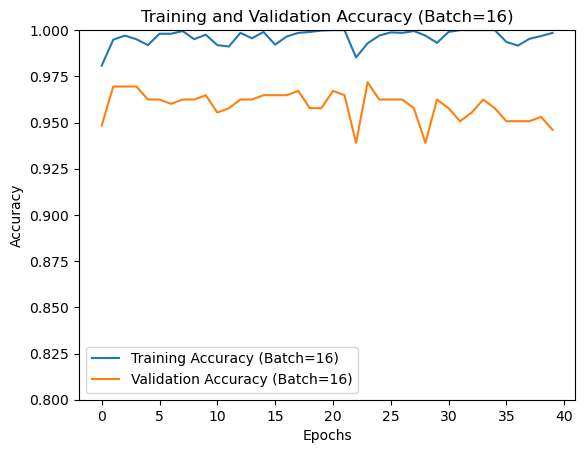

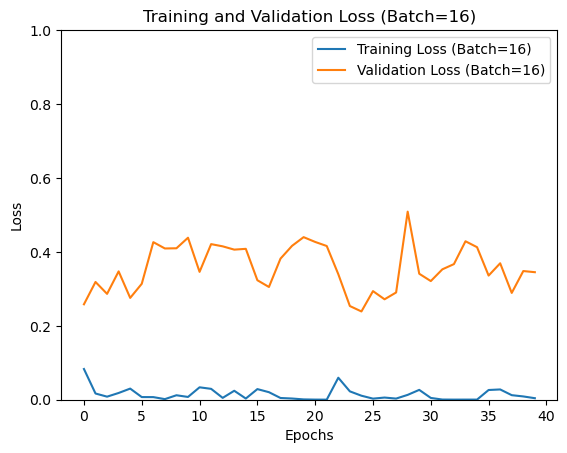

In [49]:
# Plot training and validation accuracy for batch size 16
plt.plot(history_16.history['accuracy'], label='Training Accuracy (Batch=16)')
plt.plot(history_16.history['val_accuracy'], label='Validation Accuracy (Batch=16)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1)  # Set y-axis range to 0-1
plt.legend()
plt.title('Training and Validation Accuracy (Batch=16)')
plt.show()

# Plot training and validation loss for batch size 16
plt.plot(history_16.history['loss'], label='Training Loss (Batch=16)')
plt.plot(history_16.history['val_loss'], label='Validation Loss (Batch=16)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)  # Set y-axis range to 0-1
plt.legend()
plt.title('Training and Validation Loss (Batch=16)')
plt.show()


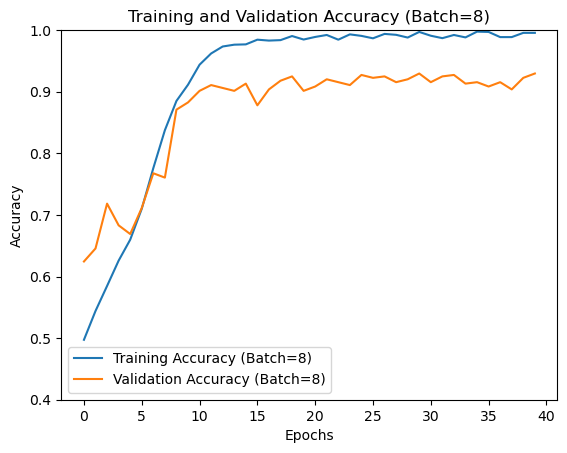

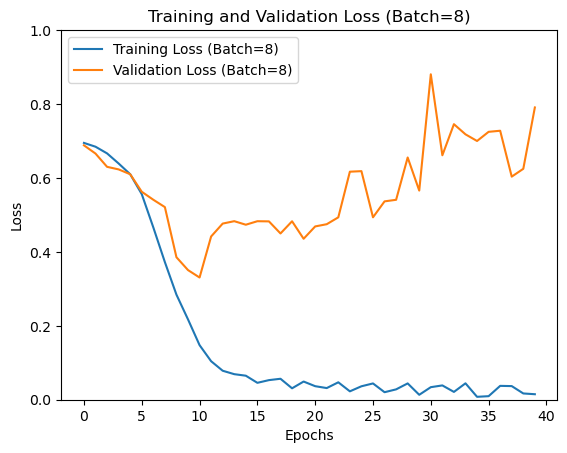

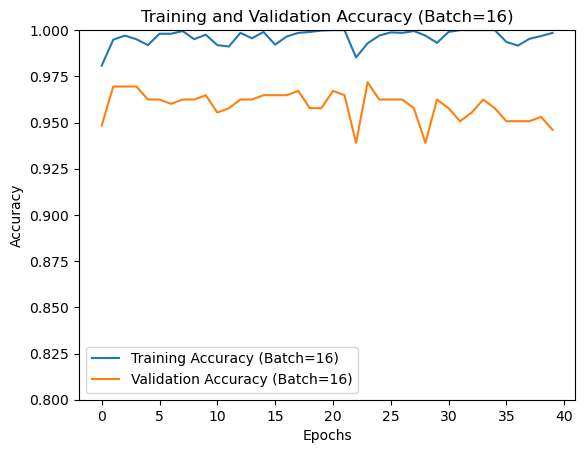

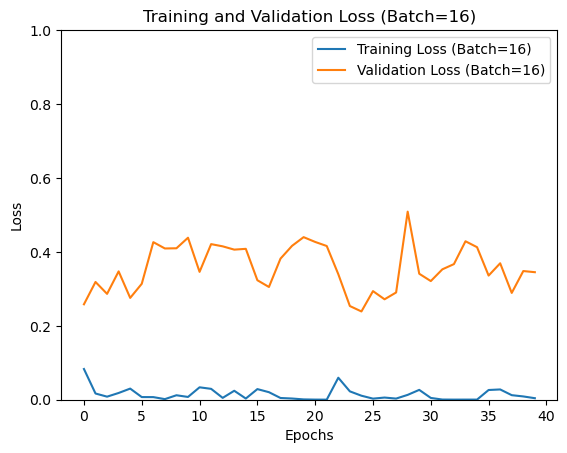

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


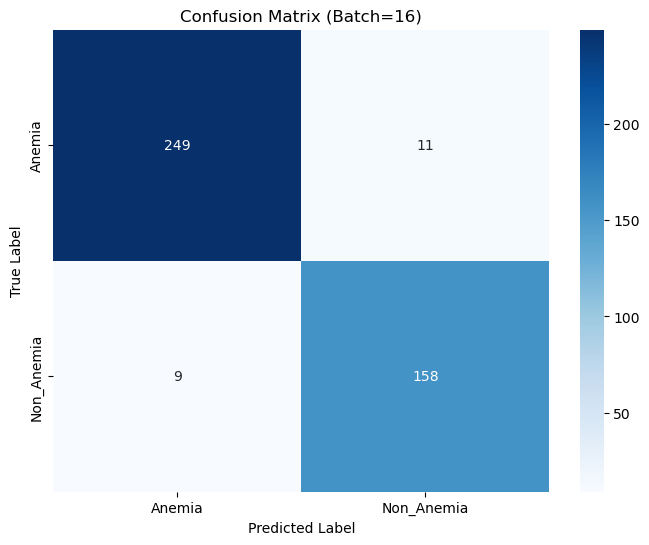

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


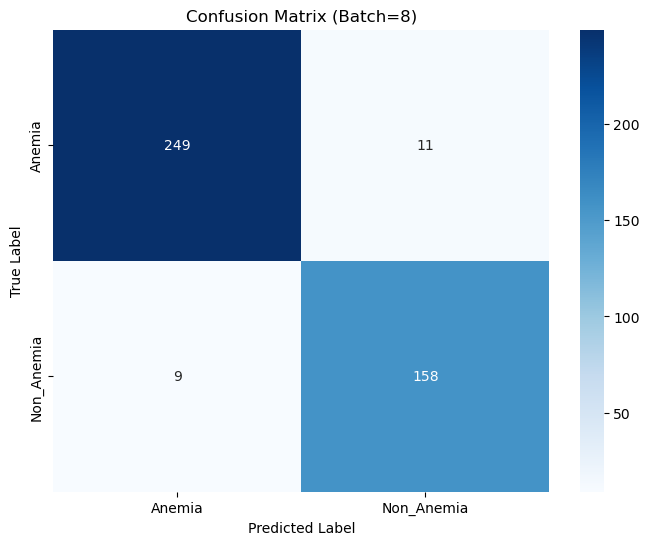

Plots and confusion matrices saved to: C:\Users\Hp\Downloads\Anemia_5\plots


In [51]:
import os

# Directory to save plots
plots_dir = os.path.join(save_dir, "plots")
os.makedirs(plots_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Save training and validation accuracy plot for batch size 8
plt.plot(history.history['accuracy'], label='Training Accuracy (Batch=8)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Batch=8)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.4, 1)
plt.legend()
plt.title('Training and Validation Accuracy (Batch=8)')
accuracy_path_8 = os.path.join(plots_dir, 'accuracy_batch8.png')
plt.savefig(accuracy_path_8)
plt.show()

# Save training and validation loss plot for batch size 8
plt.plot(history.history['loss'], label='Training Loss (Batch=8)')
plt.plot(history.history['val_loss'], label='Validation Loss (Batch=8)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()
plt.title('Training and Validation Loss (Batch=8)')
loss_path_8 = os.path.join(plots_dir, 'loss_batch8.png')
plt.savefig(loss_path_8)
plt.show()

# Save training and validation accuracy plot for batch size 16
plt.plot(history_16.history['accuracy'], label='Training Accuracy (Batch=16)')
plt.plot(history_16.history['val_accuracy'], label='Validation Accuracy (Batch=16)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1)
plt.legend()
plt.title('Training and Validation Accuracy (Batch=16)')
accuracy_path_16 = os.path.join(plots_dir, 'accuracy_batch16.png')
plt.savefig(accuracy_path_16)
plt.show()

# Save training and validation loss plot for batch size 16
plt.plot(history_16.history['loss'], label='Training Loss (Batch=16)')
plt.plot(history_16.history['val_loss'], label='Validation Loss (Batch=16)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()
plt.title('Training and Validation Loss (Batch=16)')
loss_path_16 = os.path.join(plots_dir, 'loss_batch16.png')
plt.savefig(loss_path_16)
plt.show()

# Generate and save confusion matrix for batch size 16
y_pred_16 = (model.predict(x_test) > 0.5).astype("int32")
conf_matrix_16 = confusion_matrix(y_test, y_pred_16)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_16, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (Batch=16)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
confusion_path_16 = os.path.join(plots_dir, 'confusion_matrix_batch16.png')
plt.savefig(confusion_path_16)
plt.show()

# Generate and save confusion matrix for batch size 8 (if retraining was done separately)
y_pred_8 = (model.predict(x_test) > 0.5).astype("int32")  # Assuming no weight changes from batch=8
conf_matrix_8 = confusion_matrix(y_test, y_pred_8)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_8, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (Batch=8)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
confusion_path_8 = os.path.join(plots_dir, 'confusion_matrix_batch8.png')
plt.savefig(confusion_path_8)
plt.show()

print(f"Plots and confusion matrices saved to: {plots_dir}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


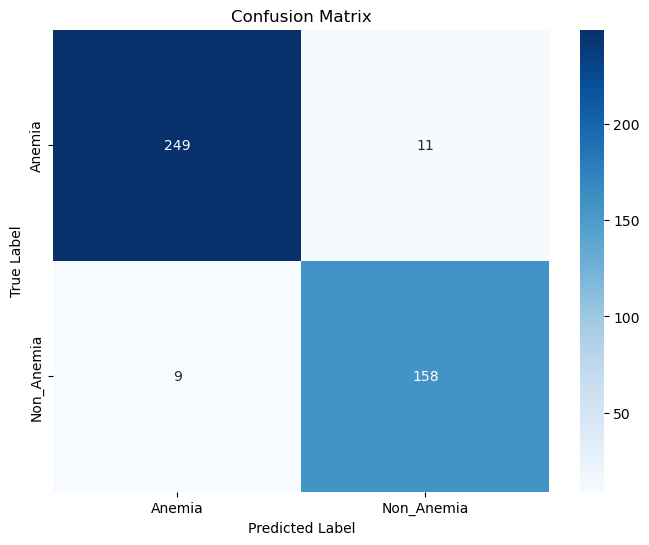

Accuracy: 0.95
Precision: 0.93
Recall: 0.95
F1 Score: 0.94
ROC-AUC Score: 0.99

Classification Report:

              precision    recall  f1-score   support

      Anemia       0.97      0.96      0.96       260
  Non_Anemia       0.93      0.95      0.94       167

    accuracy                           0.95       427
   macro avg       0.95      0.95      0.95       427
weighted avg       0.95      0.95      0.95       427

Evaluation metrics saved to C:\Users\Hp\Downloads\Anemia_5\evaluation_metrics.txt


In [53]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions (for probabilities, use model.predict())
y_pred_prob = model.predict(x_test)  # Predicted probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Binary predictions

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Precision
precision = precision_score(y_test, y_pred)

# Recall
recall = recall_score(y_test, y_pred)

# F1 Score
f1 = f1_score(y_test, y_pred)

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
confusion_matrix_path = os.path.join(save_dir, "confusion_matrix.png")
plt.savefig(confusion_matrix_path)
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred, target_names=le.classes_)

# Print results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print("\nClassification Report:\n")
print(class_report)

# Save metrics to a text file
metrics_path = os.path.join(save_dir, "evaluation_metrics.txt")
with open(metrics_path, "w") as f:
    f.write(f"Accuracy: {accuracy:.2f}\n")
    f.write(f"Precision: {precision:.2f}\n")
    f.write(f"Recall: {recall:.2f}\n")
    f.write(f"F1 Score: {f1:.2f}\n")
    f.write(f"ROC-AUC Score: {roc_auc:.2f}\n")
    f.write("\nClassification Report:\n")
    f.write(class_report)

print(f"Evaluation metrics saved to {metrics_path}")


Loaded model from C:\Users\Hp\Downloads\Anemia_5\model_checkpoint.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


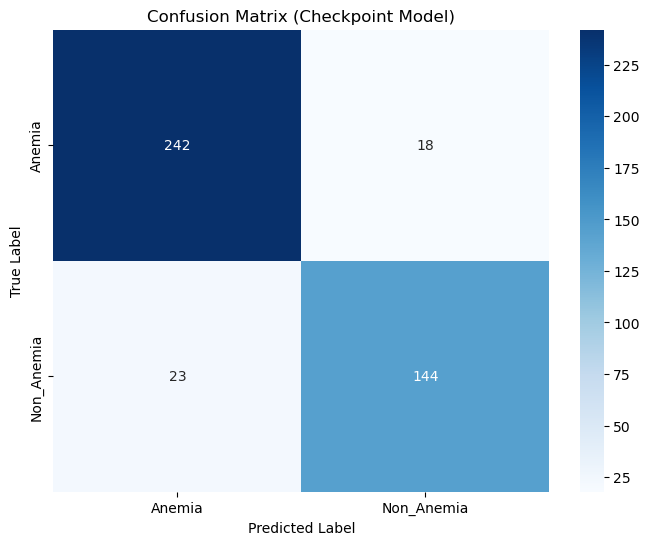

Checkpoint Model - Accuracy: 0.90
Checkpoint Model - Precision: 0.89
Checkpoint Model - Recall: 0.86
Checkpoint Model - F1 Score: 0.88
Checkpoint Model - ROC-AUC Score: 0.95

Checkpoint Model - Classification Report:

              precision    recall  f1-score   support

      Anemia       0.91      0.93      0.92       260
  Non_Anemia       0.89      0.86      0.88       167

    accuracy                           0.90       427
   macro avg       0.90      0.90      0.90       427
weighted avg       0.90      0.90      0.90       427

Checkpoint evaluation metrics saved to C:\Users\Hp\Downloads\Anemia_5\evaluation_metrics_checkpoint_8.txt


In [55]:
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Load the saved model
checkpoint_model_path = os.path.join(save_dir, 'model_checkpoint.keras')
model_checkpoint = load_model(checkpoint_model_path)
print(f"Loaded model from {checkpoint_model_path}")

# Generate predictions using the checkpoint model
y_pred_prob_checkpoint = model_checkpoint.predict(x_test)  # Predicted probabilities
y_pred_checkpoint = (y_pred_prob_checkpoint > 0.5).astype("int32")  # Binary predictions

# Calculate metrics for the checkpoint model
accuracy_checkpoint = accuracy_score(y_test, y_pred_checkpoint)
precision_checkpoint = precision_score(y_test, y_pred_checkpoint)
recall_checkpoint = recall_score(y_test, y_pred_checkpoint)
f1_checkpoint = f1_score(y_test, y_pred_checkpoint)
roc_auc_checkpoint = roc_auc_score(y_test, y_pred_prob_checkpoint)

# Confusion Matrix for the checkpoint model
conf_matrix_checkpoint = confusion_matrix(y_test, y_pred_checkpoint)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_checkpoint, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (Checkpoint Model)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
confusion_matrix_checkpoint_path = os.path.join(save_dir, "confusion_matrix_checkpoint_8.png")
plt.savefig(confusion_matrix_checkpoint_path)
plt.show()

# Classification Report for the checkpoint model
class_report_checkpoint = classification_report(y_test, y_pred_checkpoint, target_names=le.classes_)

# Print results for the checkpoint model
print(f"Checkpoint Model - Accuracy: {accuracy_checkpoint:.2f}")
print(f"Checkpoint Model - Precision: {precision_checkpoint:.2f}")
print(f"Checkpoint Model - Recall: {recall_checkpoint:.2f}")
print(f"Checkpoint Model - F1 Score: {f1_checkpoint:.2f}")
print(f"Checkpoint Model - ROC-AUC Score: {roc_auc_checkpoint:.2f}")
print("\nCheckpoint Model - Classification Report:\n")
print(class_report_checkpoint)

# Save metrics to a text file for the checkpoint model
metrics_checkpoint_path = os.path.join(save_dir, "evaluation_metrics_checkpoint_8.txt")
with open(metrics_checkpoint_path, "w") as f:
    f.write(f"Checkpoint Model - Accuracy: {accuracy_checkpoint:.2f}\n")
    f.write(f"Checkpoint Model - Precision: {precision_checkpoint:.2f}\n")
    f.write(f"Checkpoint Model - Recall: {recall_checkpoint:.2f}\n")
    f.write(f"Checkpoint Model - F1 Score: {f1_checkpoint:.2f}\n")
    f.write(f"Checkpoint Model - ROC-AUC Score: {roc_auc_checkpoint:.2f}\n")
    f.write("\nCheckpoint Model - Classification Report:\n")
    f.write(class_report_checkpoint)

print(f"Checkpoint evaluation metrics saved to {metrics_checkpoint_path}")


Loaded model from C:\Users\Hp\Downloads\Anemia_5\model_checkpoint_batch16.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


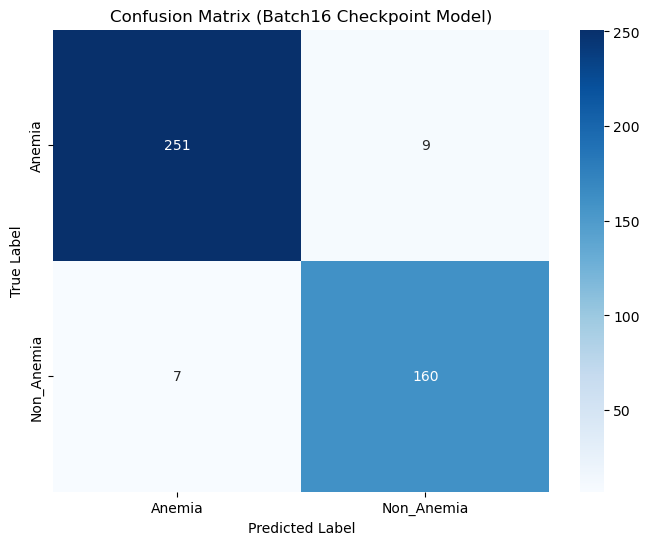

Batch16 Checkpoint Model - Accuracy: 0.96
Batch16 Checkpoint Model - Precision: 0.95
Batch16 Checkpoint Model - Recall: 0.96
Batch16 Checkpoint Model - F1 Score: 0.95
Batch16 Checkpoint Model - ROC-AUC Score: 0.99

Batch16 Checkpoint Model - Classification Report:

              precision    recall  f1-score   support

      Anemia       0.97      0.97      0.97       260
  Non_Anemia       0.95      0.96      0.95       167

    accuracy                           0.96       427
   macro avg       0.96      0.96      0.96       427
weighted avg       0.96      0.96      0.96       427

Batch16 Checkpoint evaluation metrics saved to C:\Users\Hp\Downloads\Anemia_5\evaluation_metrics_batch16_checkpoint.txt


In [57]:
# Load the saved model for batch size 16
checkpoint_model_batch16_path = os.path.join(save_dir, 'model_checkpoint_batch16.keras')
model_checkpoint_batch16 = load_model(checkpoint_model_batch16_path)
print(f"Loaded model from {checkpoint_model_batch16_path}")

# Generate predictions using the batch16 checkpoint model
y_pred_prob_batch16 = model_checkpoint_batch16.predict(x_test)  # Predicted probabilities
y_pred_batch16 = (y_pred_prob_batch16 > 0.5).astype("int32")  # Binary predictions

# Calculate metrics for the batch16 checkpoint model
accuracy_batch16 = accuracy_score(y_test, y_pred_batch16)
precision_batch16 = precision_score(y_test, y_pred_batch16)
recall_batch16 = recall_score(y_test, y_pred_batch16)
f1_batch16 = f1_score(y_test, y_pred_batch16)
roc_auc_batch16 = roc_auc_score(y_test, y_pred_prob_batch16)

# Confusion Matrix for the batch16 checkpoint model
conf_matrix_batch16 = confusion_matrix(y_test, y_pred_batch16)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_batch16, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (Batch16 Checkpoint Model)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
confusion_matrix_batch16_path = os.path.join(save_dir, "confusion_matrix_batch16_checkpoint.png")
plt.savefig(confusion_matrix_batch16_path)
plt.show()

# Classification Report for the batch16 checkpoint model
class_report_batch16 = classification_report(y_test, y_pred_batch16, target_names=le.classes_)

# Print results for the batch16 checkpoint model
print(f"Batch16 Checkpoint Model - Accuracy: {accuracy_batch16:.2f}")
print(f"Batch16 Checkpoint Model - Precision: {precision_batch16:.2f}")
print(f"Batch16 Checkpoint Model - Recall: {recall_batch16:.2f}")
print(f"Batch16 Checkpoint Model - F1 Score: {f1_batch16:.2f}")
print(f"Batch16 Checkpoint Model - ROC-AUC Score: {roc_auc_batch16:.2f}")
print("\nBatch16 Checkpoint Model - Classification Report:\n")
print(class_report_batch16)

# Save metrics to a text file for the batch16 checkpoint model
metrics_batch16_path = os.path.join(save_dir, "evaluation_metrics_batch16_checkpoint.txt")
with open(metrics_batch16_path, "w") as f:
    f.write(f"Batch16 Checkpoint Model - Accuracy: {accuracy_batch16:.2f}\n")
    f.write(f"Batch16 Checkpoint Model - Precision: {precision_batch16:.2f}\n")
    f.write(f"Batch16 Checkpoint Model - Recall: {recall_batch16:.2f}\n")
    f.write(f"Batch16 Checkpoint Model - F1 Score: {f1_batch16:.2f}\n")
    f.write(f"Batch16 Checkpoint Model - ROC-AUC Score: {roc_auc_batch16:.2f}\n")
    f.write("\nBatch16 Checkpoint Model - Classification Report:\n")
    f.write(class_report_batch16)

print(f"Batch16 Checkpoint evaluation metrics saved to {metrics_batch16_path}")


In [8]:
import os
import numpy as np
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint

In [10]:
# Paths
data_dir = 'C:\\Users\\Hp\\Downloads\\Anemia_2'
save_dir = 'C:\\Users\\Hp\\Downloads\\Anemia_5'

# Load and preprocess data
data = []
dirs = os.listdir(data_dir)

for i in dirs:
    path = os.path.join(data_dir, i)
    for img in os.listdir(path):
        image = cv.imread(os.path.join(path, img))
        image = cv.resize(image, (128, 128))  # Resize to 128x128
        data.append([image, i])

images = []
labels = []

for img, lab in data:
    images.append(img)
    labels.append(lab)

# Convert to numpy arrays and normalize images
images = np.array(images) / 255.0  # Normalize pixel values
labels = np.array(labels)

# Encode labels
le = LabelEncoder()
labels = le.fit_transform(labels)

# Split data into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.2, random_state=42
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42
)

# Reshape data for SMOTE (SMOTE requires 2D data)
x_train_flat = x_train.reshape((x_train.shape[0], -1))

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_flat, y_train)

# Reshape data back to original dimensions
x_train_resampled = x_train_resampled.reshape((-1, 128, 128, 3))

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train_resampled), 
    y=y_train_resampled
)
class_weights = dict(enumerate(class_weights))

print(f"Class Weights: {class_weights}")

Class Weights: {0: 1.0, 1: 1.0}


In [12]:
from xgboost import XGBClassifier

Training Random Forest...


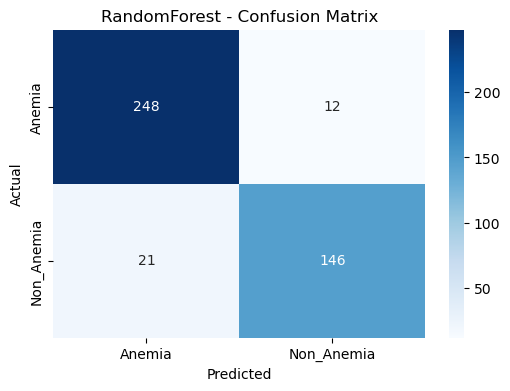

--- RandomForest Results ---
Accuracy: 0.9227
Precision: 0.9241
Recall: 0.8743
F1 Score: 0.8985

Classification Report:
               precision    recall  f1-score   support

      Anemia       0.92      0.95      0.94       260
  Non_Anemia       0.92      0.87      0.90       167

    accuracy                           0.92       427
   macro avg       0.92      0.91      0.92       427
weighted avg       0.92      0.92      0.92       427

Training XGBoost...


C:\Users\Hp\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:23:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


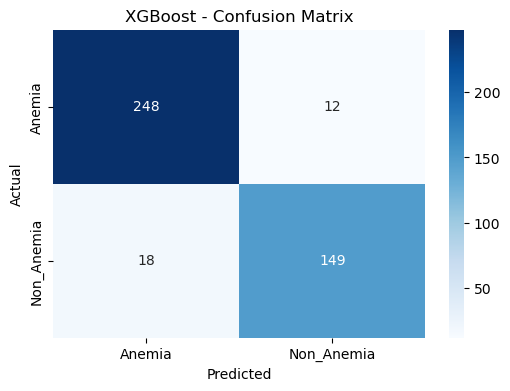

--- XGBoost Results ---
Accuracy: 0.9297
Precision: 0.9255
Recall: 0.8922
F1 Score: 0.9085
ROC-AUC Score: 0.9814

Classification Report:
               precision    recall  f1-score   support

      Anemia       0.93      0.95      0.94       260
  Non_Anemia       0.93      0.89      0.91       167

    accuracy                           0.93       427
   macro avg       0.93      0.92      0.93       427
weighted avg       0.93      0.93      0.93       427

Training SVM...


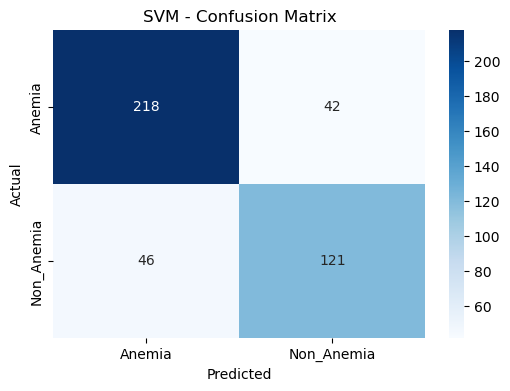

--- SVM Results ---
Accuracy: 0.7939
Precision: 0.7423
Recall: 0.7246
F1 Score: 0.7333
ROC-AUC Score: 0.8791

Classification Report:
               precision    recall  f1-score   support

      Anemia       0.83      0.84      0.83       260
  Non_Anemia       0.74      0.72      0.73       167

    accuracy                           0.79       427
   macro avg       0.78      0.78      0.78       427
weighted avg       0.79      0.79      0.79       427



TypeError: unsupported format string passed to NoneType.__format__

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Assuming x_train_resampled, y_train_resampled, x_test, and y_test are already prepared
# Flatten the data for non-CNN models
x_train_flat = x_train_resampled.reshape(x_train_resampled.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Dictionary to store model results
model_results = {}

# Function to evaluate a model
def evaluate_model(name, model, x_test, y_test, y_pred_prob=None):
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob) if y_pred_prob is not None else None

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(os.path.join(save_dir, f'{name}_confusion_matrix.png'))
    plt.show()

    # Save results
    model_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC-AUC': roc_auc
    }

    # Print classification report
    print(f"--- {name} Results ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# 1. Random Forest
print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train_flat, y_train_resampled)
evaluate_model('RandomForest', rf, x_test_flat, y_test)

# 2. XGBoost
print("Training XGBoost...")
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(x_train_flat, y_train_resampled)
y_pred_prob_xgb = xgb.predict_proba(x_test_flat)[:, 1]
evaluate_model('XGBoost', xgb, x_test_flat, y_test, y_pred_prob_xgb)

# 3. Support Vector Machine (SVM)
print("Training SVM...")
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(x_train_flat, y_train_resampled)
y_pred_prob_svm = svm.predict_proba(x_test_flat)[:, 1]
evaluate_model('SVM', svm, x_test_flat, y_test, y_pred_prob_svm)

# Compare Results
results_path = os.path.join(save_dir, 'model_comparison_results.txt')
with open(results_path, 'w') as f:
    f.write("Model Comparison Results:\n")
    for name, metrics in model_results.items():
        f.write(f"\n{name}:\n")
        for metric, value in metrics.items():
            f.write(f"{metric}: {value:.4f}\n")

# Print final comparison
print("\n--- Model Comparison ---")
for name, metrics in model_results.items():
    print(f"\n{name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

print(f"\nModel comparison results saved to {results_path}")


In [37]:
import tensorflow_hub as hub


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training ResNet50...
Epoch 1/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.5042 - loss: 0.7128
Epoch 1: val_accuracy improved from -inf to 0.57042, saving model to C:\Users\Hp\Downloads\Anemia_5\ResNet50_checkpoint.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 92s 325ms/step - accuracy: 0.5042 - loss: 0.7127 - val_accuracy: 0.5704 - val_loss: 0.6877
Epoch 2/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.5200 - loss: 0.6914
Epoch 2: val_accuracy did not improve from 0.57042
254/254 ━━━━━━━━━━━━━━━━━━━━ 79s 312ms/step - accuracy: 0.5200 - loss: 0.6914 - val_accuracy: 0.4390 - val_loss: 0.6914
Epoch 3/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.5514 - loss: 0.6824
Epoch 3: val_accuracy did not improve from 0.57042
254/254 ━━━━━━━━━━━━━━━━━━━━ 79s 312ms/step - accuracy: 0.5514 - loss: 0.6824 - val_accuracy: 0.4085 - val_loss: 0.6950
Epoch 4/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.5407 - los

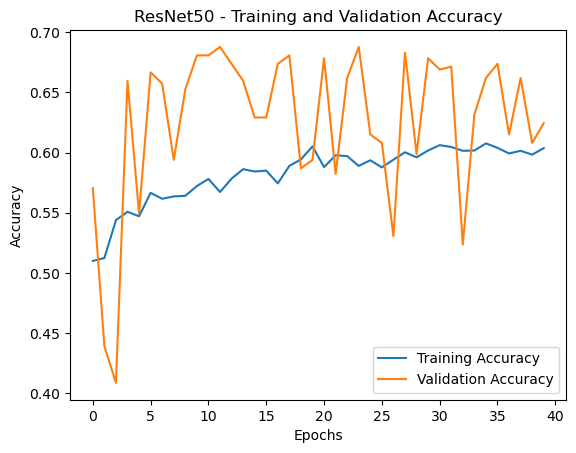

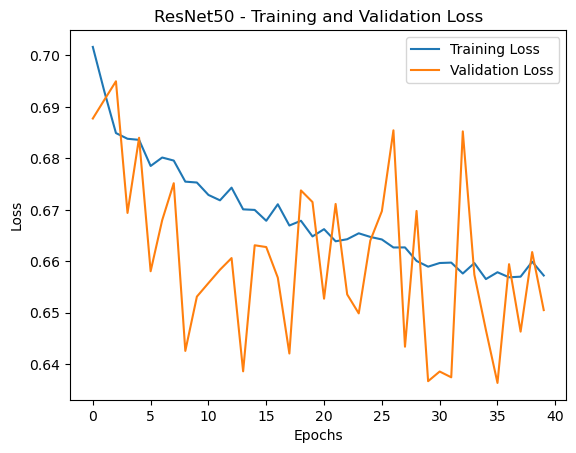

14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 704ms/step


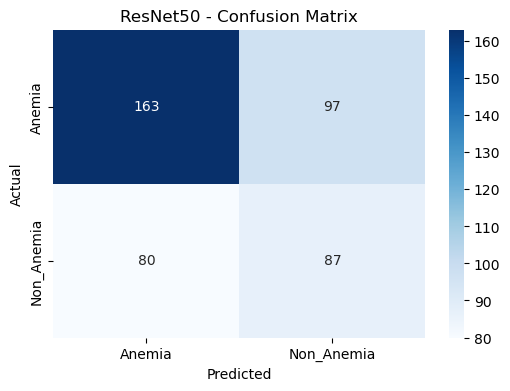

--- ResNet50 Results ---
Accuracy: 0.5855
Precision: 0.4728
Recall: 0.5210
F1 Score: 0.4957
Training MobileNetV2...
Epoch 1/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5173 - loss: 0.8065
Epoch 1: val_accuracy improved from -inf to 0.65023, saving model to C:\Users\Hp\Downloads\Anemia_5\MobileNetV2_checkpoint.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 32s 102ms/step - accuracy: 0.5174 - loss: 0.8063 - val_accuracy: 0.6502 - val_loss: 0.6138
Epoch 2/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6323 - loss: 0.6558
Epoch 2: val_accuracy improved from 0.65023 to 0.68545, saving model to C:\Users\Hp\Downloads\Anemia_5\MobileNetV2_checkpoint.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.6323 - loss: 0.6558 - val_accuracy: 0.6854 - val_loss: 0.6085
Epoch 3/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6795 - loss: 0.6088
Epoch 3: val_accuracy did not improve from 0.68545
254/254 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.6794 - loss: 0.

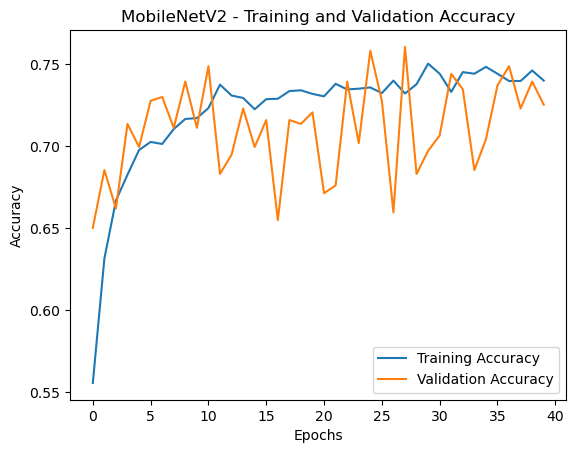

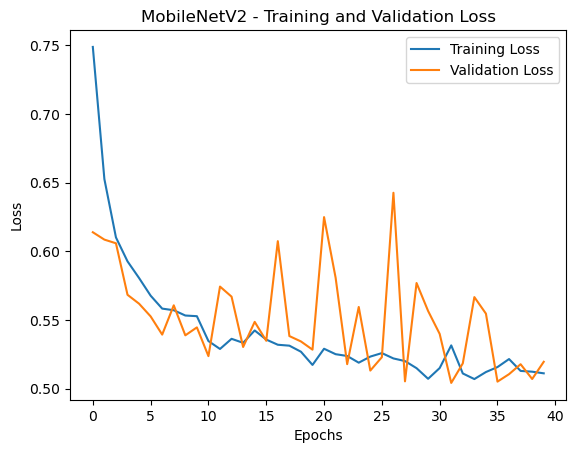

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 274ms/step


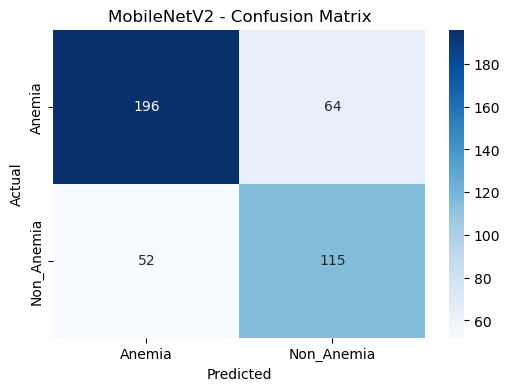

--- MobileNetV2 Results ---
Accuracy: 0.7283
Precision: 0.6425
Recall: 0.6886
F1 Score: 0.6647

--- Model Comparison ---
ResNet50: Accuracy=0.5855, Precision=0.4728, Recall=0.5210, F1 Score=0.4957
MobileNetV2: Accuracy=0.7283, Precision=0.6425, Recall=0.6886, F1 Score=0.6647


In [41]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Paths
save_dir = 'C:\\Users\\Hp\\Downloads\\Anemia_5'

# Function to plot metrics
def plot_metrics(history, model_name):
    # Accuracy plot
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.savefig(os.path.join(save_dir, f'{model_name}_accuracy.png'))
    plt.show()

    # Loss plot
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.savefig(os.path.join(save_dir, f'{model_name}_loss.png'))
    plt.show()

# Function to evaluate model
def evaluate_model(model, x_test, y_test, model_name):
    y_pred_prob = model.predict(x_test)
    y_pred = (y_pred_prob > 0.5).astype("int32")
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(os.path.join(save_dir, f'{model_name}_confusion_matrix.png'))
    plt.show()

    print(f"--- {model_name} Results ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    return accuracy, precision, recall, f1

# Define a function to create and train a model
def create_and_train_model(base_model, model_name):
    # Freeze base model layers
    base_model.trainable = False

    # Add custom classification head
    inputs = Input(shape=(128, 128, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define checkpoint
    checkpoint_path = os.path.join(save_dir, f'{model_name}_checkpoint.keras')
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

    # Train the model
    history = model.fit(
        x_train_resampled, y_train_resampled,
        validation_data=(x_val, y_val),
        epochs=40,
        batch_size=16,
        callbacks=[checkpoint]
    )

    # Plot training metrics
    plot_metrics(history, model_name)

    # Evaluate the model
    accuracy, precision, recall, f1 = evaluate_model(model, x_test, y_test, model_name)

    return model, accuracy, precision, recall, f1

# Load ResNet50 and MobileNetV2 pretrained models
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
mobilenetv2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Train and evaluate ResNet50
print("Training ResNet50...")
resnet50_model, resnet50_acc, resnet50_prec, resnet50_rec, resnet50_f1 = create_and_train_model(resnet50_base, 'ResNet50')

# Train and evaluate MobileNetV2
print("Training MobileNetV2...")
mobilenetv2_model, mobilenetv2_acc, mobilenetv2_prec, mobilenetv2_rec, mobilenetv2_f1 = create_and_train_model(mobilenetv2_base, 'MobileNetV2')

# Compare results
print("\n--- Model Comparison ---")
print(f"ResNet50: Accuracy={resnet50_acc:.4f}, Precision={resnet50_prec:.4f}, Recall={resnet50_rec:.4f}, F1 Score={resnet50_f1:.4f}")
print(f"MobileNetV2: Accuracy={mobilenetv2_acc:.4f}, Precision={mobilenetv2_prec:.4f}, Recall={mobilenetv2_rec:.4f}, F1 Score={mobilenetv2_f1:.4f}")


In [81]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Paths
save_dir = 'C:\\Users\\Hp\\Downloads\\Anemia_5'

# Plot training metrics
def plot_metrics(history, model_name):
    # Accuracy plot
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.savefig(os.path.join(save_dir, f'{model_name}_accuracy.png'))
    plt.show()

    # Loss plot
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.savefig(os.path.join(save_dir, f'{model_name}_loss.png'))
    plt.show()

# Evaluate the model
def evaluate_model(model, x_test, y_test, model_name):
    y_pred_prob = model.predict(x_test)
    y_pred = (y_pred_prob > 0.5).astype("int32")
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(os.path.join(save_dir, f'{model_name}_confusion_matrix.png'))
    plt.show()

    print(f"--- {model_name} Results ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    return accuracy, precision, recall, f1


Epoch 1/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.5226 - loss: 0.8651
Epoch 1: val_accuracy improved from -inf to 0.62441, saving model to C:\Users\Hp\Downloads\Anemia_5\ResNet50_checkpoint.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 144s 512ms/step - accuracy: 0.5226 - loss: 0.8648 - val_accuracy: 0.6244 - val_loss: 0.9874
Epoch 2/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.5571 - loss: 0.7111
Epoch 2: val_accuracy did not improve from 0.62441
254/254 ━━━━━━━━━━━━━━━━━━━━ 125s 494ms/step - accuracy: 0.5570 - loss: 0.7111 - val_accuracy: 0.6080 - val_loss: 0.6450
Epoch 3/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.5761 - loss: 0.6979
Epoch 3: val_accuracy improved from 0.62441 to 0.63380, saving model to C:\Users\Hp\Downloads\Anemia_5\ResNet50_checkpoint.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 124s 486ms/step - accuracy: 0.5761 - loss: 0.6979 - val_accuracy: 0.6338 - val_loss: 0.8461
Epoch 4/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0

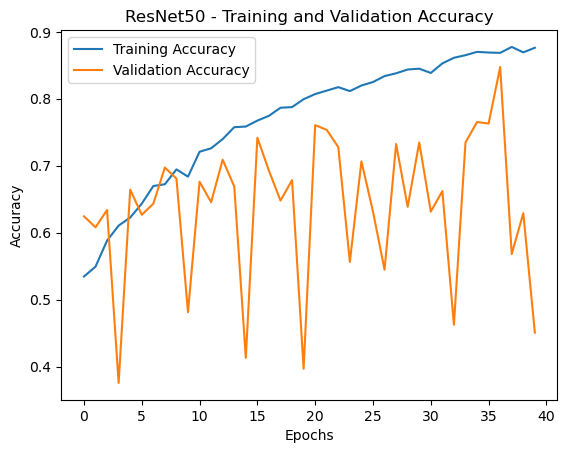

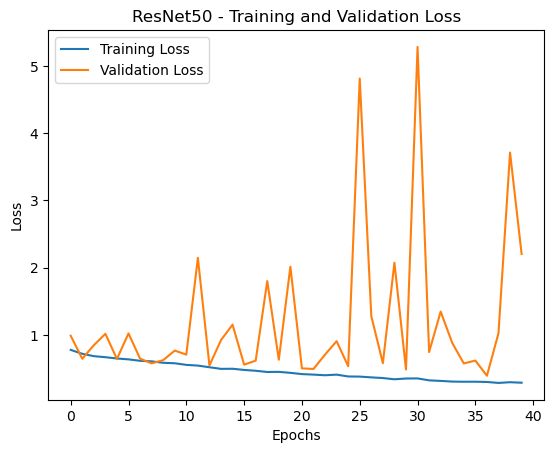

14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 686ms/step


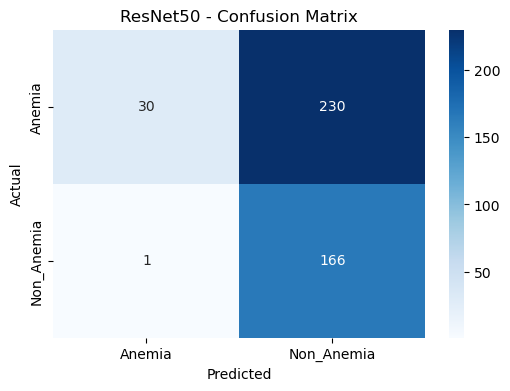

--- ResNet50 Results ---
Accuracy: 0.4590
Precision: 0.4192
Recall: 0.9940
F1 Score: 0.5897


In [83]:
# Load ResNet50
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Fine-tune last 30 layers
for layer in resnet50_base.layers[:-30]:
    layer.trainable = False
for layer in resnet50_base.layers[-30:]:
    layer.trainable = True

# Create ResNet50 Model
inputs = Input(shape=(128, 128, 3))
x = resnet50_base(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)
resnet50_model = Model(inputs, outputs)

# Compile ResNet50 Model
resnet50_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define checkpoint for ResNet50
resnet50_checkpoint_path = os.path.join(save_dir, 'ResNet50_checkpoint.keras')
resnet50_checkpoint = ModelCheckpoint(resnet50_checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train ResNet50
resnet50_history = resnet50_model.fit(
    x_train_resampled, y_train_resampled,
    validation_data=(x_val, y_val),
    epochs=40,
    batch_size=16,
    callbacks=[resnet50_checkpoint]
)

# Plot metrics and evaluate ResNet50
plot_metrics(resnet50_history, 'ResNet50')
resnet50_acc, resnet50_prec, resnet50_rec, resnet50_f1 = evaluate_model(resnet50_model, x_test, y_test, 'ResNet50')


14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 643ms/step


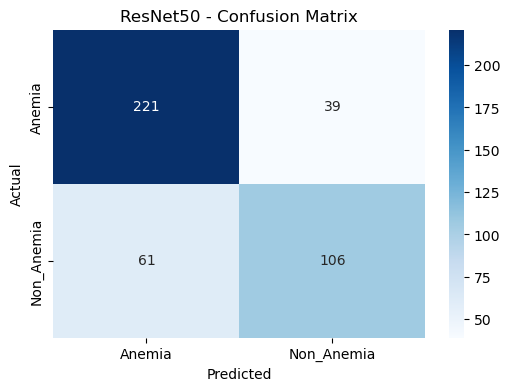

Classification Report:

              precision    recall  f1-score   support

      Anemia       0.78      0.85      0.82       260
  Non_Anemia       0.73      0.63      0.68       167

    accuracy                           0.77       427
   macro avg       0.76      0.74      0.75       427
weighted avg       0.76      0.77      0.76       427



In [87]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Paths
save_dir = 'C:\\Users\\Hp\\Downloads\\Anemia_5'
resnet50_checkpoint_path = os.path.join(save_dir, 'ResNet50_checkpoint.keras')

# Load the saved ResNet50 model
resnet50_model = load_model(resnet50_checkpoint_path)

# Make predictions
y_pred_prob = resnet50_model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('ResNet50 - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(os.path.join(save_dir, 'ResNet50_loaded_confusion_matrix.png'))
plt.show()

# Print classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Epoch 1/80
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5403 - loss: 0.8182
Epoch 1: val_accuracy improved from -inf to 0.65493, saving model to C:\Users\Hp\Downloads\Anemia_5\MobileNetV2_checkpoint.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 30s 96ms/step - accuracy: 0.5404 - loss: 0.8179 - val_accuracy: 0.6549 - val_loss: 0.6001
Epoch 2/80
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6336 - loss: 0.6611
Epoch 2: val_accuracy improved from 0.65493 to 0.69249, saving model to C:\Users\Hp\Downloads\Anemia_5\MobileNetV2_checkpoint.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.6336 - loss: 0.6611 - val_accuracy: 0.6925 - val_loss: 0.5806
Epoch 3/80
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6497 - loss: 0.6263
Epoch 3: val_accuracy improved from 0.69249 to 0.71831, saving model to C:\Users\Hp\Downloads\Anemia_5\MobileNetV2_checkpoint.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step - accuracy: 0.6498 - loss: 0.6263 - val_accuracy: 0.7183 - val_lo

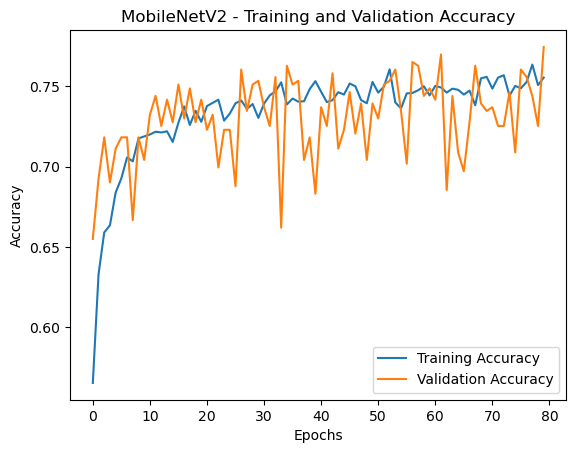

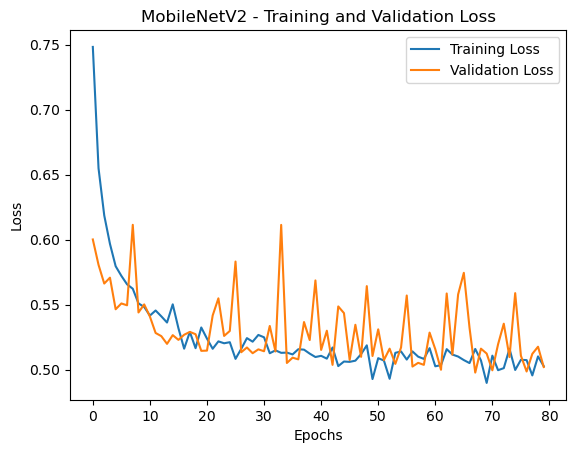

14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 292ms/step


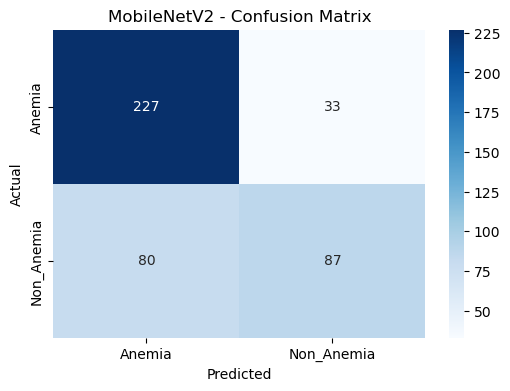

--- MobileNetV2 Results ---
Accuracy: 0.7354
Precision: 0.7250
Recall: 0.5210
F1 Score: 0.6063


In [89]:
# Load MobileNetV2
mobilenetv2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all MobileNetV2 layers
mobilenetv2_base.trainable = False

# Create MobileNetV2 Model
inputs = Input(shape=(128, 128, 3))
x = mobilenetv2_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)
mobilenetv2_model = Model(inputs, outputs)

# Compile MobileNetV2 Model
mobilenetv2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define checkpoint for MobileNetV2
mobilenetv2_checkpoint_path = os.path.join(save_dir, 'MobileNetV2_checkpoint.keras')
mobilenetv2_checkpoint = ModelCheckpoint(mobilenetv2_checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train MobileNetV2
mobilenetv2_history = mobilenetv2_model.fit(
    x_train_resampled, y_train_resampled,
    validation_data=(x_val, y_val),
    epochs=80,
    batch_size=16,
    callbacks=[mobilenetv2_checkpoint]
)

# Plot metrics and evaluate MobileNetV2
plot_metrics(mobilenetv2_history, 'MobileNetV2')
mobilenetv2_acc, mobilenetv2_prec, mobilenetv2_rec, mobilenetv2_f1 = evaluate_model(mobilenetv2_model, x_test, y_test, 'MobileNetV2')


In [91]:
# Compare Results
print("\n--- Model Comparison ---")
print(f"ResNet50: Accuracy={resnet50_acc:.4f}, Precision={resnet50_prec:.4f}, Recall={resnet50_rec:.4f}, F1 Score={resnet50_f1:.4f}")
print(f"MobileNetV2: Accuracy={mobilenetv2_acc:.4f}, Precision={mobilenetv2_prec:.4f}, Recall={mobilenetv2_rec:.4f}, F1 Score={mobilenetv2_f1:.4f}")



--- Model Comparison ---
ResNet50: Accuracy=0.4590, Precision=0.4192, Recall=0.9940, F1 Score=0.5897
MobileNetV2: Accuracy=0.7354, Precision=0.7250, Recall=0.5210, F1 Score=0.6063


In [ ]:
# Save the final trained ResNet50 model
resnet50_model.save(os.path.join(save_dir, 'ResNet50_final.keras'))

# Save the final trained MobileNetV2 model
mobilenetv2_model.save(os.path.join(save_dir, 'MobileNetV2_final.keras'))
